This script evaluates the quality of the estimated graphs using data from the roll-call votes of the U.S. congress. The solution obtained with the graph learning algorithm based on motifs is compared with different baselines.

In [87]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import src.utils as utils
import spectral_nti as snti

import pygsp

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)
PATH = './results/senate/'
DATASET_PATH = 'data/senate_data/'

## Considered constraints

In [88]:
GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-0.5*lamd_t).T@lamd,
]

## Auxiliary functions

In [89]:
def get_colors(labels):
    colors = []
    for i in range(labels.size):
        if labels[i] == 'R':
            colors.append('red')
        elif labels[i] == 'D':
            colors.append('blue')
        elif labels[i] == 'M':
            colors.append('yellow')
        else:
            raise Exception('Unknown node label')
    return colors


def est_graph(id, models, MM, X, iters):
    N = X.shape[0]
    L_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i,M in enumerate(MM):
        C_hat = np.cov(X[:,:M])

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters) 
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {} - Time(sec): {:.3}'.format(id, M, model['name'], t))
    return L_hat, lamd_hat


def est_errs(L, lamd, L_hat, lams_hat, sq_err=True):
    norm_L = np.linalg.norm(L, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)
    
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(MM, models, err, ylab, logy=True, ylim=[], skip=[]):
    plt.figure()
    for i, model in enumerate(models):
        if i in skip:
            continue
        if logy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                         linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('M')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def prune_edges(A, max_edges):
    sorted_edges = np.sort(A.flatten())[::-1]
    A_aux = np.copy(A)
    A_aux[A_aux < sorted_edges[max_edges]] = 0
    return A_aux

## Read data and estimate true graph

In [90]:
X113 = np.load(DATASET_PATH + 'X113.npy')
X114 = np.load(DATASET_PATH + 'X114.npy')
X115 = np.load(DATASET_PATH + 'X115.npy')
labels113 = np.load(DATASET_PATH + 'labels113.npy')
labels114 = np.load(DATASET_PATH + 'labels114.npy')
labels115 = np.load(DATASET_PATH + 'labels115.npy')

C113 = np.cov(X113)
C114 = np.cov(X114)
C115 = np.cov(X115)

colors113 = get_colors(labels113)
colors114 = get_colors(labels114)
colors115 = get_colors(labels115)


## Read graphs

In [6]:
regs114 = {'alpha': .005, 'beta': 10}

L0, _ = snti.MGL(C114, [], [], [], regs114, max_iters=200, verbose=False)
A0 = np.diag(np.diag(L0)) - L0
lambdas0, _ = np.linalg.eigh(L0)

regs115 = {'alpha': .005, 'beta': 5}
L, _ = snti.MGL(C115, [], [], [], regs115, max_iters=200, verbose=False)
A = np.diag(np.diag(L)) - L
lambdas, _ = np.linalg.eigh(L)

2.721222132245592 3.868810235935885
2.0168224594683455 3.114028737388097
	c-0: c: 3.869	c0: 2.721	err: 1.147588	err norm: 0.421718
	c-1: c: 24.487	c0: 12.013	err: 12.474075	err norm: 1.038361
	c-2: c: 0.122	c0: 0.178	err: -0.055899	err norm: -0.313730
	c-3: c: 3.220	c0: 0.962	err: 2.257828	err norm: 2.346057


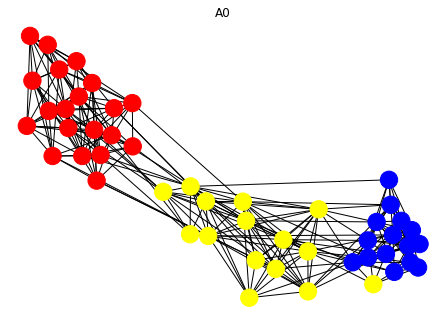

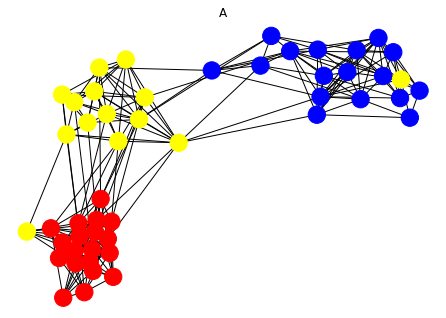

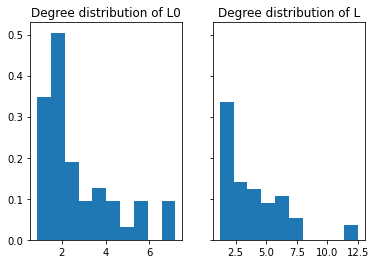

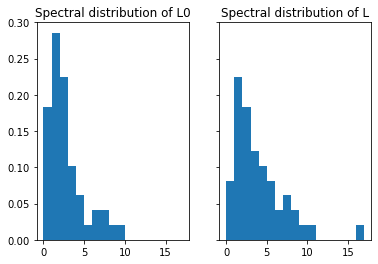

In [6]:
plt.figure()
nx.draw_spring(nx.from_numpy_matrix(A0), node_color=colors114)
plt.title('A0')

plt.figure()
nx.draw_spring(nx.from_numpy_matrix(A), node_color=colors115)
plt.title('A')

degrees0  = np.diag(L0)
degrees  = np.diag(L)
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(degrees0, density=True)
axs[0].set_title('Degree distribution of L0')
axs[1].hist(degrees, density=True)
axs[1].set_title('Degree distribution of L')

print(np.mean(degrees0), np.mean(degrees))
print(np.median(degrees0), np.median(degrees))

n_bins = np.arange(0,np.amax(lambdas)+1,1)

figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True, bins=n_bins)
axs[0].set_title('Spectral distribution of L0')
axs[1].hist(lambdas, density=True, bins=n_bins)
axs[1].set_title('Spectral distribution of L')

cs, _ = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

### Experiment parameters

In [8]:
n_covs = 100
MM = np.arange(100, 301, 25)
iters = 200

# regs 1
deltas = [1.2, 13, .06, 2.3]
models = [
    # Baselines
    {'name': 'GLasso', 'alpha': 0.1, 'fmt': '^-'},
    {'name': 'MGL-Tr=1', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': .5, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*-', 'regs': {'alpha': 0, 'beta': 5, 
     'c1': .01, 'c2': 20, 'conn_comp': 1}},
    {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
     'regs': {'alpha': .005, 'beta': 5, 'gamma': 0, 'deltas': []}},

    # Our algorithms
    {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': .7, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': .9, 'gamma': 5000, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': .4, 'gamma': 10000, 'deltas': deltas[3]}},
]

### Run and plot experiment

In [8]:
# Estimate graph
N = L.shape[0]
total_t = time.time()
Ls_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

X_perms = [np.random.permutation(X115.T).T for i in range(n_covs)]
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, X_perms[i][:,:MM[-1]], iters)
            for i in range(n_covs))
for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 75.33634969393412  mins -----


In [79]:
# %matplotlib qt
skip_idx = []
err_L, err_lamb = est_errs(L, lambdas, Ls_hat, lamds_hat, sq_err=True)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err2 L', logy=True, skip=skip_idx)


In [15]:
# fname = PATH + 'senate.csv'
# utils.error_to_csv(fname, models, MM, mean_errL)

SAVED as: ./results/senate/senate.csv


## Plot estimated graphs

In [97]:
M_idx = 0
idx = 25

L_poly = Ls_hat[:,:,6,M_idx,idx]
L_sgl = Ls_hat[:,:,2,M_idx,idx]
L_unc = Ls_hat[:,:,3,M_idx,idx]
L_heat = Ls_hat[:,:,5,M_idx,idx]
A = np.diag(np.diag(L)) - L
A_poly = np.diag(np.diag(L_poly)) - L_poly
A_sgl = np.diag(np.diag(L_sgl)) - L_sgl
A_unc = np.diag(np.diag(L_unc)) - L_unc
A_heat = np.diag(np.diag(L_heat)) - L_heat

max_edges = 500
show_labels = True

# All images
G_A = nx.from_numpy_matrix(prune_edges(A, max_edges))
G_unc = nx.from_numpy_matrix(prune_edges(A_unc, max_edges))
G_sgl = nx.from_numpy_matrix(prune_edges(A_sgl, max_edges))
G_poly = nx.from_numpy_matrix(prune_edges(A_poly, max_edges))
G_heat = nx.from_numpy_matrix(prune_edges(A_heat, max_edges))

_, axs = plt.subplots(2,2)
nx.draw_spring(G_A, node_color=colors115, ax=axs[0][0], with_labels=show_labels)
axs[0][0].set_title('True graph')
nx.draw_spring(G_poly, node_color=colors115, ax=axs[0][1], with_labels=show_labels)
axs[0][1].set_title('Poly estimate')
nx.draw_spring(G_sgl, node_color=colors115, ax=axs[1][0], with_labels=show_labels)
axs[1][0].set_title('SGL estimate')
nx.draw_spring(G_unc, node_color=colors115, ax=axs[1][1], with_labels=show_labels)
axs[1][1].set_title('Unc estimate')


Text(0.5, 1.0, 'Unc estimate')

In [33]:
M_idx = 2
idx = 25

L_poly = Ls_hat[:,:,6,M_idx,idx]
L_sgl = Ls_hat[:,:,2,M_idx,idx]
L_unc = Ls_hat[:,:,3,M_idx,idx]
L_heat = Ls_hat[:,:,5,M_idx,idx]

A = np.diag(np.diag(L)) - L
A_poly = np.diag(np.diag(L_poly)) - L_poly
A_sgl = np.diag(np.diag(L_sgl)) - L_sgl
A_unc = np.diag(np.diag(L_unc)) - L_unc
A_heat = np.diag(np.diag(L_heat)) - L_heat

max_edges = 500
show_labels = True

_, axs = plt.subplots(2,2)
nx.draw_spring(nx.from_numpy_matrix(prune_edges(A_sgl, max_edges)), node_color=colors115, ax=axs[0][0], with_labels=show_labels)
axs[0][0].set_title('SGL')
nx.draw_spring(nx.from_numpy_matrix(prune_edges(A_poly, max_edges)), node_color=colors115, ax=axs[0][1], with_labels=show_labels)
axs[0][1].set_title('Poly estimate')
nx.draw_spring(nx.from_numpy_matrix(prune_edges(A_heat, max_edges)), node_color=colors115, ax=axs[1][0], with_labels=show_labels)
axs[1][0].set_title('Heat estimate')
nx.draw_spring(nx.from_numpy_matrix(prune_edges(A_unc, max_edges)), node_color=colors115, ax=axs[1][1], with_labels=show_labels)
axs[1][1].set_title('Unc estimate')


In [24]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]

# data = {
#     'regs114': regs114,
#     'regs115': regs115,
#     'L0': L0,
#     'L': L,
#     'lambdas': lambdas,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux,
#     'colors': colors115,
# }
# file = 'senate_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/senate/' + file, data)

In [91]:
# %matplotlib qt

# # Load data
# file = 'senate_100covs_200iters.npy'
# data = np.load(PATH + file, allow_pickle=True).item()
# models = data['models']

# L0 = data['L0']
# lambdas = data['lambdas']
# L = data['L']
# Ls_hat = data['Ls_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']
# regs114 = data['regs114']
# regs115 = data['regs115']
# # colors = data['colors']
# lambdas0, _ = np.linalg.eigh(L0)